For blog post https://jina.ai/news/submodular-optimization-for-text-selection-passage-reranking-context-engineering

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from transformers import AutoModel, AutoProcessor, AutoTokenizer
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import heapq

# Initialize the model (this may take a moment)
print("Loading model...")
model = AutoModel.from_pretrained("jinaai/jina-embeddings-v4", trust_remote_code=True, torch_dtype=torch.float16, device_map='cuda')
preprocessor = AutoProcessor.from_pretrained('jinaai/jina-embeddings-v4', trust_remote_code=True)
print("Model loaded successfully!")

Loading model...


config.json: 0.00B [00:00, ?B/s]

configuration_jina_embeddings_v4.py:   0%|          | 0.00/750 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-embeddings-v4:
- configuration_jina_embeddings_v4.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_jina_embeddings_v4.py: 0.00B [00:00, ?B/s]

custom_lora_module.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-embeddings-v4:
- custom_lora_module.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


qwen2_5_vl.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-embeddings-v4:
- qwen2_5_vl.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-embeddings-v4:
- modeling_jina_embeddings_v4.py
- custom_lora_module.py
- qwen2_5_vl.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.51G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json: 0.00B [00:00, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/126 [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/900 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/360M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Model loaded successfully!


In [39]:
import pandas as pd
import requests

# Set your delimiter and URL
DELIMITER = '\n\n'
url = "https://jina.ai/news/submodular-optimization-for-diverse-query-generation-in-deepresearch"

# Fetch content using Jina Reader
response = requests.get(f"https://r.jina.ai/{url}")
content = response.text

# Split content by delimiter
passages = content.split(DELIMITER)

# Remove empty chunks
passages = [p.strip() for p in passages if p.strip()]

# Create pandas DataFrame
df = pd.DataFrame({
   'passages': passages,
})
df

,passages
0,Title: Submodular Optimization for Diverse Que...
1,URL Source: https://jina.ai/news/submodular-op...
2,Published Time: 2025-07-04T05:36:02.000+02:00
3,Markdown Content:\nWhen implementing DeepResea...
4,While understanding the importance of diverse ...
...,...
90,### [](https://jina.ai/news/submodular-optimiz...
91,"Without a principled framework, you might reso..."
92,"Finally, submodular optimization is a well-stu..."
93,"[submodularity.org: Tutorials, References, Act..."


In [40]:
pa_embed = model.encode_text(
            texts=passages,
            task="retrieval",
            prompt_name="passage",
            return_numpy=True
        )
pa_embed2 = model.encode_text(
            texts=passages,
            task="text-matching",
            prompt_name="query",
            return_numpy=True
        )
corr_pa = cosine_similarity(pa_embed2)
pa_embed.shape

Encoding texts...: 100%|██████████| 12/12 [00:04<00:00,  2.57it/s]


(95, 2048)

In [41]:
queries = ['what is diminishing return']

q_embed = model.encode_text(
            texts=queries,
            task="retrieval",
            prompt_name="query",
            return_numpy=True
        )


# Calculate cosine similarity between query and all passage chunks
qp_sim = cosine_similarity(q_embed, pa_embed)
scores = np.sum(qp_sim, axis=0)  # Get flat array of scores

# Create pandas DataFrame
df = pd.DataFrame({
   'passage': passages,
   'similarity_score': scores,
})

# Sort by similarity score (highest first)
df_sorted = df.sort_values('similarity_score', ascending=False).reset_index(drop=True)

# Display the results
print("Chunks ranked by similarity to query:")
df_sorted

Encoding texts...: 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

Chunks ranked by similarity to query:


,passage,similarity_score
0,"![Image 7: Graph titled ""Diminishing Return"" w...",0.739111
1,Now let's apply this concept to our query gene...,0.624708
2,Consider placing Wi-Fi routers to provide inte...,0.588639
3,Before trying to brutally solve the subset sel...,0.582604
4,In plain English: adding an element to a small...,0.550099
...,...,...
90,![Image 2: Four side-by-side graphs analyze qu...,0.349975
91,We use `gemini-2.5-flash` as the LLM with the ...,0.347531
92,![Image 10: Two line graphs comparing query si...,0.342773
93,![Image 12: Two side-by-side line graphs compa...,0.337939


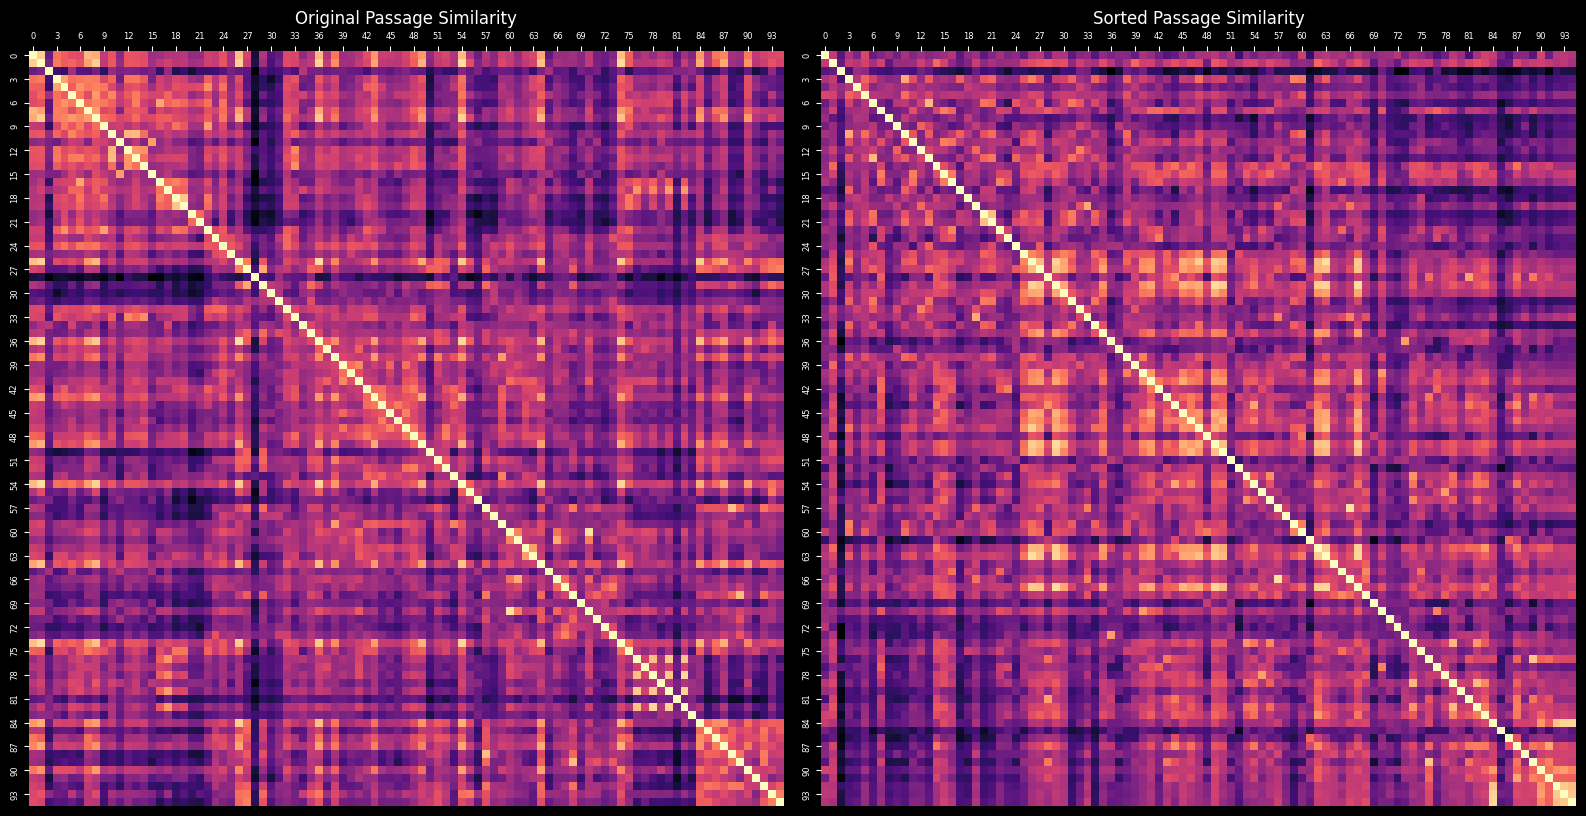

In [42]:
# Get the sorted indices from your DataFrame
sorted_indices = df_sorted.index.tolist()

# If you need the original indices before sorting, use this instead:
original_sorted_indices = df.sort_values('similarity_score', ascending=False).index.tolist()

# Rearrange the correlation matrix according to sorted indices
corr_pa_sorted = corr_pa[original_sorted_indices][:, original_sorted_indices]

import matplotlib.pyplot as plt
import seaborn as sns

# Set dark theme
plt.style.use('dark_background')

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Original correlation matrix
sns.heatmap(corr_pa,
          annot=False,
          square=True,
          cmap='magma',
          cbar=False,  # Remove colorbar
          ax=ax1)
ax1.set_title('Original Passage Similarity', color='white')
ax1.xaxis.set_label_position('top')
ax1.xaxis.tick_top()
ax1.tick_params(axis='both', which='major', labelsize=6, colors='white')

# Sorted correlation matrix
sns.heatmap(corr_pa_sorted,
          annot=False,
          square=True,
          cmap='magma',
          cbar=False,  # Remove colorbar
          ax=ax2)
ax2.set_title('Sorted Passage Similarity', color='white')
ax2.xaxis.set_label_position('top')
ax2.xaxis.tick_top()
ax2.tick_params(axis='both', which='major', labelsize=6, colors='white')

plt.tight_layout()
plt.show()

In [43]:
import numpy as np
import heapq
import pandas as pd

def facility_location(S, query_sim, passage_sim):
   """f(S) = sum_q sum_i max_j∈S sim(q,j) * sim(i,j)"""
   if len(S) == 0:
       return 0

   Q, P = query_sim.shape
   # query_sim[q, S] shape: [Q, |S|]
   # passage_sim[:, S] shape: [P, |S|]

   # For each query q and passage i, compute max_j∈S sim(q,j) * sim(i,j)
   query_selected = query_sim[:, S]  # [Q, |S|]
   passage_selected = passage_sim[:, S]  # [P, |S|]

   # Broadcast: [Q, 1, |S|] * [1, P, |S|] = [Q, P, |S|]
   coverage = query_selected[:, None, :] * passage_selected[None, :, :]

   # Take max over selected passages for each (q,i) pair, then sum over all
   max_coverage = np.max(coverage, axis=2)  # [Q, P]
   return np.sum(max_coverage)

def max_coverage(S, query_sim, passage_sim, lam=0.5):
    """f(S) = sum_q sum_i∈S r_qi + λ sum_q sum_i min(r_qi, max_j∈S s_ij)"""
    if len(S) == 0:
        return 0

    Q, P = query_sim.shape

    # Relevance term: sum over all queries and selected passages (monotonic)
    relevance = np.sum(query_sim[:, S])

    # Coverage term: how well S covers ALL passages (monotonic)
    # For each passage, take max similarity to any selected passage
    max_sim_to_selected = np.max(passage_sim[:, S], axis=1)  # [P]

    # Coverage is weighted by query relevance and capped by similarity
    coverage_values = np.minimum(query_sim, max_sim_to_selected[None, :])  # [Q, P]
    coverage = np.sum(coverage_values)

    return relevance + lam * coverage

def max_coverage_old(S, query_sim, passage_sim, lam=0.5):
   """f(S) = sum_q sum_i∈S r_qi + λ sum_q sum_i∉S max_j∈S s_ij"""
   if len(S) == 0:
       return 0

   Q, P = query_sim.shape

   # Relevance term: sum over all queries and selected passages
   relevance = np.sum(query_sim[:, S])

   # Coverage term: for unselected passages
   unselected = [i for i in range(P) if i not in S]
   if len(unselected) == 0:
       coverage = 0
   else:
       # Max similarity of unselected to selected
       coverage_matrix = passage_sim[np.ix_(unselected, S)]  # [|unselected|, |S|]
       max_coverage = np.max(coverage_matrix, axis=1)  # [|unselected|]
       coverage = Q * np.sum(max_coverage)  # Multiply by Q since we sum over all queries

   return relevance + lam * coverage

def saturated_coverage(S, query_sim, passage_sim):
   """f(S) = sum_q sum_i min(r_qi, max_j∈S s_ij)"""
   if len(S) == 0:
       return 0

   Q, P = query_sim.shape

   # Max similarity to selected passages for each passage
   max_sim_to_selected = np.max(passage_sim[:, S], axis=1)  # [P]

   # For each query, compute min(relevance, max_similarity)
   # query_sim: [Q, P], max_sim_to_selected: [P]
   # Broadcast to [Q, P]
   saturated_values = np.minimum(query_sim, max_sim_to_selected[None, :])

   return np.sum(saturated_values)

def marginal_gain(candidate, S, obj_func, *args):
   """Compute f(S ∪ {candidate}) - f(S)"""
   return obj_func(S + [candidate], *args) - obj_func(S, *args)

def lazy_greedy(obj_func, k, *args):
   """Lazy greedy algorithm for submodular maximization"""
   P = args[1].shape[1]  # Get P from passage_sim matrix (now query_sim is [Q, P])
   S = []
   pq = [(-marginal_gain(i, S, obj_func, *args), 0, i) for i in range(P)]
   heapq.heapify(pq)

   for iteration in range(k):
       while True:
           neg_gain, last_updated, candidate = heapq.heappop(pq)

           if candidate in S:
               continue

           if last_updated < iteration:
               new_gain = marginal_gain(candidate, S, obj_func, *args)
               heapq.heappush(pq, (-new_gain, iteration, candidate))
               continue
           else:
               S.append(candidate)
               break

   return S

In [44]:
# Usage
k = 10

# Normalize both to [0,1] before using
relevance_norm = (qp_sim - qp_sim.min()) / (qp_sim.max() - qp_sim.min())
passage_sim_norm = (corr_pa - corr_pa.min()) / (corr_pa.max() - corr_pa.min())

# Run all three methods
selected_qo = lazy_greedy(max_coverage, k, relevance_norm, passage_sim_norm, 0)
selected_fl = lazy_greedy(facility_location, k, relevance_norm, passage_sim_norm)
selected_mc = lazy_greedy(max_coverage, k, relevance_norm, passage_sim_norm, 10)
selected_sc = lazy_greedy(saturated_coverage, k, relevance_norm, passage_sim_norm)

# Create baseline ranking
baseline_indices = np.argsort(qp_sim[0])[::-1].tolist()

# Create comparison table with passage texts
def create_selection_df(selected_indices, method_name):
   return pd.DataFrame({
       f'ID': selected_indices,
       f'Rel': [f"{qp_sim[0, idx]:.3f}" for idx in selected_indices],
       f'Text': [passages[idx] for idx in selected_indices]
   })



df_qo = create_selection_df(selected_qo, 'QO')
df_fl = create_selection_df(selected_fl, 'FL')
df_sc = create_selection_df(selected_sc, 'SC')

# Concatenate horizontally
comparison_df = pd.concat([df_qo, df_fl, df_sc], axis=1)
comparison_df.index.name = 'Rank'
comparison_df.index = comparison_df.index + 1
comparison_df

,ID,Rel,Text,ID,Rel,Text,ID,Rel,Text
Rank,,,,,,,,,
1,34,0.739,"![Image 7: Graph titled ""Diminishing Return"" w...",34,0.739,"![Image 7: Graph titled ""Diminishing Return"" w...",35,0.534,From [one of my old slides back in AAAI 2013](...
2,32,0.625,Now let's apply this concept to our query gene...,32,0.625,Now let's apply this concept to our query gene...,34,0.739,"![Image 7: Graph titled ""Diminishing Return"" w..."
3,28,0.589,Consider placing Wi-Fi routers to provide inte...,27,0.583,Before trying to brutally solve the subset sel...,28,0.589,Consider placing Wi-Fi routers to provide inte...
4,27,0.583,Before trying to brutally solve the subset sel...,28,0.589,Consider placing Wi-Fi routers to provide inte...,32,0.625,Now let's apply this concept to our query gene...
5,31,0.550,In plain English: adding an element to a small...,31,0.550,In plain English: adding an element to a small...,0,0.421,Title: Submodular Optimization for Diverse Que...
6,35,0.534,From [one of my old slides back in AAAI 2013](...,89,0.513,"Moreover, the lazy greedy algorithm is dramati...",1,0.436,URL Source: https://jina.ai/news/submodular-op...
7,89,0.513,"Moreover, the lazy greedy algorithm is dramati...",72,0.489,1. Maintain a priority queue of elements sor...,2,0.394,Published Time: 2025-07-04T05:36:02.000+02:00
8,42,0.495,One caveat is this function only _implicitly_ ...,0,0.421,Title: Submodular Optimization for Diverse Que...,3,0.416,Markdown Content:\nWhen implementing DeepResea...
9,30,0.490,f(A∪v)−f(A)≥f(B∪v)−f(B)f(A \cup {v}) - f(A) \g...,1,0.436,URL Source: https://jina.ai/news/submodular-op...,4,0.425,While understanding the importance of diverse ...


Running lazy greedy algorithms...
Computing function values...
Completed k=5
Completed k=10
Completed k=15
Completed k=20
Completed k=25
Completed k=30
Completed k=35
Completed k=40
Completed k=45
Completed k=50
Completed k=55
Completed k=60
Completed k=65
Completed k=70
Completed k=75
Completed k=80
Completed k=85
Completed k=90


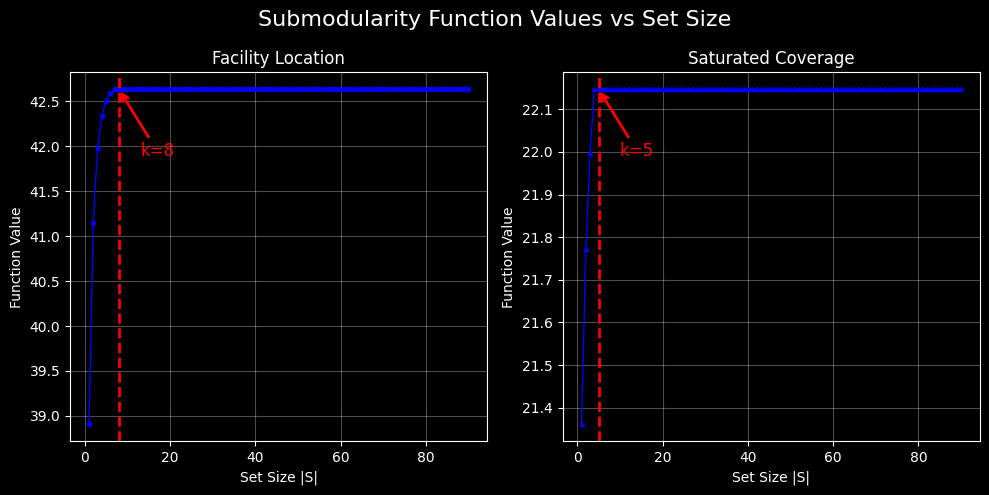


Function Statistics:
Facility Location: min=38.91, max=42.64, saturation at k=8
Saturated Coverage: min=21.36, max=22.15, saturation at k=5


In [45]:
import numpy as np
import heapq
import pandas as pd
import matplotlib.pyplot as plt

max_k = 90
lam = 2
# Normalize both to [0,1] before using
relevance_norm = (qp_sim - qp_sim.min()) / (qp_sim.max() - qp_sim.min())
passage_sim_norm = (corr_pa - corr_pa.min()) / (corr_pa.max() - corr_pa.min())

# Define functions and their parameters
functions = [
    ("Facility Location", facility_location, 'b-o', [relevance_norm, passage_sim_norm]),
    ("Saturated Coverage", saturated_coverage, 'b-^', [relevance_norm, passage_sim_norm])
]

# Run lazy greedy once for each function to get the optimal sequence
print("Running lazy greedy algorithms...")
sequences = []
for name, func, _, params in functions:
    S = lazy_greedy(func, max_k, *params)
    sequences.append(S)

# Compute function values for each prefix of the greedy sequence
x_values = range(1, max_k + 1)
all_values = []

print("Computing function values...")
for i, (name, func, _, params) in enumerate(functions):
    values = []
    for k in x_values:
        # Use the first k elements from each greedy sequence
        values.append(func(sequences[i][:k], *params))

        if k % 5 == 0 and i == 0:  # Print progress only once
            print(f"Completed k={k}")

    all_values.append(values)

# Function to find saturation point
def find_saturation_point(values, threshold=1e-3):
    """Find the point where the delta falls below threshold"""
    for i in range(1, len(values)):
        delta = values[i] - values[i-1]
        if delta < threshold:
            return i + 1  # +1 because x_values starts from 1
    return len(values)  # Return last point if no saturation found

# Create the plots
fig, axes = plt.subplots(1, len(functions), figsize=(5*len(functions), 5))
fig.suptitle('Submodularity Function Values vs Set Size', fontsize=16)

for i, (name, _, style, _) in enumerate(functions):
    axes[i].plot(x_values, all_values[i], style, linewidth=1, markersize=3)
    axes[i].set_xlabel('Set Size |S|')
    axes[i].set_ylabel('Function Value')
    axes[i].set_title(name if name != "Max Coverage" else f"Max Coverage (λ={lam})")
    axes[i].grid(True, alpha=0.3)

    # Find and annotate saturation point
    saturation_k = find_saturation_point(all_values[i])
    saturation_y = all_values[i][saturation_k - 1]  # -1 because x_values starts from 1

    # Add vertical dashed line
    axes[i].axvline(x=saturation_k, color='r', linestyle='--', linewidth=2)

    # Add annotation
    axes[i].annotate(f'k={saturation_k}',
                    xy=(saturation_k, saturation_y),
                    xytext=(saturation_k + 5, saturation_y - 0.2 * (max(all_values[i]) - min(all_values[i]))),
                    fontsize=12, color='r',
                    arrowprops=dict(arrowstyle='->', color='r', lw=2))

plt.tight_layout()
plt.show()

# Print statistics using a loop
print(f"\nFunction Statistics:")
for i, (name, _, _, _) in enumerate(functions):
    values = all_values[i]
    saturation_k = find_saturation_point(values)
    print(f"{name}: min={min(values):.2f}, max={max(values):.2f}, saturation at k={saturation_k}")